# 1. Install Library

In [2]:
#!pip install morphoTreeAdjust==0.0.9
#!pip install PrettyPrintTree

# 2. Importing library and defining plotting functions

In [25]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import morphoTreeAdjust as mta

from PrettyPrint import PrettyPrintTree
from colorama import Fore, Back

printTree = PrettyPrintTree(
    lambda node: node.children,
    lambda node: (str(node.id) + ": " +str(node.level) +": " +str(len(node.cnps))), color=Back.BLACK + Fore.WHITE,
    start_message=lambda node: f'Each node is represented by <index>: <gray level>\n'
)

def showLevelSets(img_f):
    print("Upper and lower level sets where in black are foreground pixels and white are background pixels")
    t_values = np.unique(img_f)
    len = np.size(t_values)
    max_value = np.max(img_f)
    fig, axes = plt.subplots(len, 2, figsize=(5, 15))
    
    # Preenchendo os subplots com imagens limiares
    for i, t in enumerate(t_values):
        # Primeira coluna: img_f >= t
        thr = t_values[i]
        img_threshold_ge = np.where(img_f >= thr, 1, 0)
        axes[i, 0].imshow(img_threshold_ge, cmap='gray_r', vmax=1, vmin=0, interpolation='nearest')
        axes[i, 0].set_title(f'image ≥ {t}')
        axes[i, 0].axis('off')
        axes[i, 0].add_patch(plt.Rectangle((0, 0), img_threshold_ge.shape[1] - 1, img_threshold_ge.shape[0] - 1, 
                                   edgecolor='red', linewidth=0.5, fill=False))
        # Segunda coluna: img_f <= t
        thr = t_values[len - i -1]
        img_threshold_le = np.where(img_f <= thr, 1, 0)
        axes[i, 1].imshow(img_threshold_le, cmap='gray_r',vmax=1, vmin=0, interpolation='nearest')
        axes[i, 1].set_title(f'image ≤ {thr}')
        axes[i, 1].axis('off')
        axes[i, 1].add_patch(plt.Rectangle((0, 0), img_threshold_le.shape[1] - 1, img_threshold_le.shape[0] - 1, 
                                   edgecolor='blue', linewidth=0.5, fill=False))
    
    # Ajuste de layout para evitar sobreposição
    plt.tight_layout()
    plt.show()


def computeCentroid(cnps):
    closest_pixel = cnps[len(cnps)//2]
    px, py = closest_pixel // num_cols, closest_pixel % num_cols
    return px, py
    
def showTree(tree):
    if(tree.isMaxtree):
        print("Imagem and its max-tree representation. The indexes of max-tree nodes are shown as label in the imagem.")
    else:
        print("Imagem and its min-tree representation. The indexes of min-tree nodes are shown as label in the imagem.")
    img_vector = tree.reconstructionImage()
    ids_position = []
    
    for node in tree.root.BFSTraversal():
      px, py = computeCentroid(node.cnps)
      ids_position.append( (node.id, px, py) )
    
    # Plota a imagem
    plt.figure(figsize=(8, 6))
    image = img_vector.reshape(tree.numRows, tree.numCols)
    # Adicionando uma borda ao redor da imagem
    ax = plt.gca()  # Obtém o eixo atual
    ax.add_patch(plt.Rectangle((0, 0), image.shape[1] - 1, image.shape[0] - 1, 
                               edgecolor='red', linewidth=0.5, fill=False))

    plt.imshow(image, cmap='gray')
    
    # Adiciona rótulos nos centróides fictícios
    for i, (id, x, y) in enumerate(ids_position):
        plt.text(y, x, f'•{id}', color='red', fontsize=9)

    
    plt.axis('off')
    plt.show()
    printTree(tree.root)

def showNode(node):
    image = node.recNode().reshape(num_rows, num_cols)
    ax = plt.gca()  # Obtém o eixo atual
    ax.imshow(image, cmap='gray_r')
    ax.add_patch(plt.Rectangle((0, 0), image.shape[1] - 1, image.shape[0] - 1, 
                               edgecolor='red', linewidth=0.5, fill=False))
    ax.set_title(f"{node}")
    ax.axis("off")

def buildMapIds(tree):
    mapIds = np.zeros(num_rows*num_cols) 
    for p in range(num_rows*num_cols):
        mapIds[p] = tree.getSC(p).id
    return mapIds


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

def getNodeContour(tree, node):
    adj = mta.AdjacencyRelation(num_rows, num_cols, 1.5)  # Relação de adjacência
    contour = []

    for idP in node.cnps:  # Percorre os pixels do nó
        for idQ in adj.getAdjPixels(idP):  # Verifica seus vizinhos
            sc_p = tree.getSC(idP)
            sc_q = tree.getSC(idQ)

            if sc_p and sc_q and sc_p.id != sc_q.id:  # Verifica se são nós diferentes
                pixel_x = idQ // num_cols
                pixel_y = idQ % num_cols
                contour.append((pixel_y, pixel_x))  # (x=coluna, y=linha)

    return contour



def showNodesOfSubtree(tree, root):
    image = tree.reconstructionImage().reshape(num_rows, num_cols)
    adj = mta.AdjacencyRelation(num_rows, num_cols, 1.5)
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')

    # Desenha a borda do retângulo em vermelho
    ax.add_patch(patches.Rectangle((0, 0), image.shape[1] - 1, image.shape[0] - 1, 
                                   edgecolor='red', linewidth=0.5, fill=False))

    colormap = plt.colormaps['Paired']  # Obtém a paleta de cores (versão compatível)
    ids_position = []
    map_adj = {}

    for node in root.BFSTraversal():
        contours_x = []
        contours_y = []
        color = colormap(node.id % 10)  # Seleciona cor baseada no ID do nó

        # Obtém um ponto de referência do nó para exibir seu ID
        (px, py) = computeCentroid(node.cnps)
        ids_position.append((node.id, px, py, color))
        
        contour = getNodeContour(tree, node)
        if contour:
            contour_x, contour_y = zip(*contour) if contour else ([], [])
            ax.scatter(contour_x, contour_y, color=color, s=0.5, label=f"Node {node.id}")
        
        for idP in node.cnps:
            for idQ in adj.getAdjPixels(idP):
                sc_p = tree.getSC(idP)
                sc_q = tree.getSC(idQ)
                if sc_p and sc_q and sc_p.id != sc_q.id:    
                    if idQ not in map_adj:
                        nodeQ = sc_q
                        (qx, qy) = computeCentroid(nodeQ.cnps)
                        map_adj[idQ] = (nodeQ.id, qx, qy)

                       

    
    # Plota os IDs dos nós vizinhos (em vermelho)
    for node_id, x, y in map_adj.values():
        plt.text(y, x, f'{node_id}', color='red', fontsize=9)

    # Plota os IDs dos nós no centro
    for node_id, x, y, color in ids_position:
        plt.text(y, x, f'{node_id}*', color=color, fontsize=9)

    
    ax.set_title(f"Subárvore com raiz {root}")
    ax.axis("off")  # Remove os eixos
    plt.show()


# 3. Creating the mintree and maxtree of an input image

- Image of the JMIV paper

Upper and lower level sets where in black are foreground pixels and white are background pixels


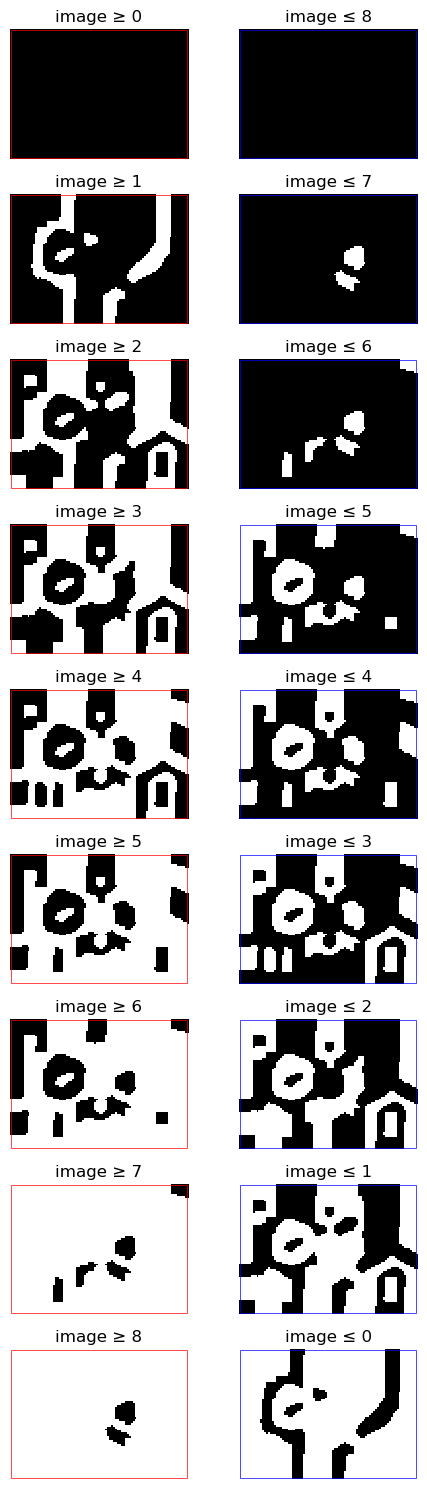




Imagem and its min-tree representation. The indexes of min-tree nodes are shown as label in the imagem.


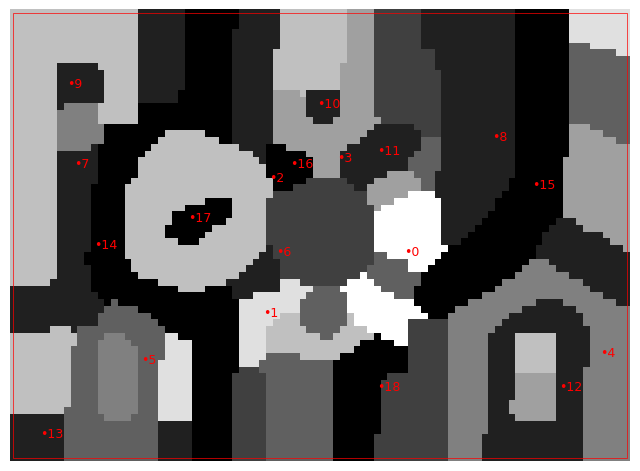

Each node is represented by <index>: <gray level>

                                                                                                 0: 8: 166 
                                                                                                     |
                                                                                                 1: 7: 180 
                                                                                                     |
                                                                                                 2: 6: 1141 
                                                                                       ┌─────────────┴──────────────┐
                                                                                   3: 5: 392                    17: 0: 44 
                                                                      ┌────────────────┴────────────────┐                 
                                                      

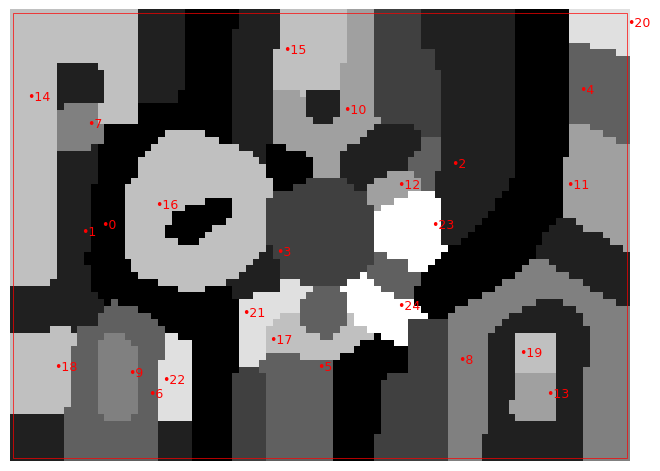

Each node is represented by <index>: <gray level>

                                                                      0: 0: 1173 
                            ┌─────────────────────────────────────────────┴──────────────────────────────────────────────┐
                        1: 1: 415                                                                                    2: 1: 986                                 
                ┌───────────┴────────────┐                                               ┌───────────────────────────────┴────────────┬──────────────────┐     
            6: 3: 221                 7: 4: 43                                       3: 2: 620                                    4: 3: 112          13: 5: 44 
    ┌───────────┼────────────┐           |                     ┌─────────────────────────┴┬───────────┬────────────┐            ┌─────┴──────┐           |     
 9: 4: 72   18: 6: 112   22: 7: 59   14: 6: 431            5: 3: 265                  8: 4: 378   10: 5:

In [29]:
img_jmiv = np.array([
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,7,7,7,7,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,5,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,1,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,1,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,1,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,1,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,5,5,5,5,6,1,1,1,1,1,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,1,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,5,5,5,5,5,1,1,1,1,1,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,4,4,4,4,4,6,6,6,6,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,5,5,5,5,5,1,1,1,1,1,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,4,4,4,4,4,4,6,6,6,6,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,5,5,5,5,5,1,1,1,1,1,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,4,4,4,4,4,4,6,6,6,6,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,5,5,5,5,5,5,1,1,1,5,5,5,5,5,5,5,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,4,4,4,4,4,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,1,1,1,1,1,1,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,4,4,4,4,4,4,4,0,0,0,0,0,0,0,0,0,6,6,6,6,6,6,0,0,0,0,1,1,1,1,1,1,5,5,5,5,5,5,5,5,5,5,5,5,5,5,1,1,1,1,1,1,1,1,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,5,5,3,3,3,3],
    [6,6,6,6,6,6,6,4,4,4,4,4,4,4,0,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,0,0,1,1,1,1,1,1,5,5,5,5,5,5,5,5,5,5,5,5,5,1,1,1,1,1,1,1,1,1,3,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,3,3],
    [6,6,6,6,6,6,6,4,4,4,4,4,1,0,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,0,0,0,5,5,5,5,5,5,5,5,5,1,1,1,1,1,1,1,1,1,1,1,3,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,0,0,0,0,0,0,5,5,5,5,5,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,0,0,0,0,0,0,0,5,5,5,5,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,0,0,0,5,5,5,5,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,0,0,0,5,5,5,5,1,1,1,1,1,1,1,5,5,5,5,3,3,3,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,0,2,2,2,2,2,2,1,1,1,1,5,5,5,5,5,5,5,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,2,2,2,2,2,2,2,2,2,1,1,5,5,5,5,5,5,5,5,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,5,5,5,5,5,5,8,8,8,8,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,5,5,5,5,8,8,8,8,8,8,8,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,6,0,0,0,0,0,0,0,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,5,8,8,8,8,8,8,8,8,8,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,0,0,0,0,0,0,0,0,0,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,8,8,8,8,8,8,8,8,8,8,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,0,0,0,0,0,0,0,0,6,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,8,8,8,8,8,8,8,8,8,8,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,8,8,8,8,8,8,8,8,8,8,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,8,8,8,8,8,8,8,8,8,8,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,0,0,0,6,6,6,6,6,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,8,8,8,8,8,8,8,8,8,8,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,8,8,8,8,8,8,8,8,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,5],
    [6,6,6,6,6,6,6,1,1,1,1,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,8,8,8,8,8,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    [6,6,6,6,6,6,6,1,1,1,1,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,8,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,8,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,1,1,1,1,1,1,1,1,1],
    [6,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,1,7,7,7,2,2,2,2,2,2,2,8,8,8,8,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,6,6,0,0,0,0,1,1,1,1,1,1,1,7,7,7,7,7,3,3,3,3,8,8,8,8,8,8,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,7,7,7,7,7,7,7,7,3,3,3,3,3,3,8,8,8,8,8,8,8,3,3,3,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1,1,1,1],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7,3,3,3,3,3,3,3,8,8,8,8,8,8,8,8,8,8,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,1,1,1,1,4,4,4,4,4,4,4,4,1,1],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7,3,3,3,3,3,3,3,8,8,8,8,8,8,8,8,8,8,8,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,7,7,7,6,6,6,3,3,3,3,3,3,3,6,8,8,8,8,8,8,8,8,8,8,8,0,0,0,4,4,4,4,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,7,7,6,6,6,6,3,3,3,3,3,3,3,6,8,8,8,8,8,8,8,8,2,2,2,2,2,2,4,4,4,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,6,6,6,1,3,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,7,7,7,7,6,6,6,6,6,6,3,3,3,3,3,6,6,6,6,8,8,8,8,8,8,2,2,2,2,2,2,4,4,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,3,3,3,3,3,3,7,7,0,0,0,0,0,0,0,0,0,7,7,7,7,6,6,6,6,6,6,6,6,3,3,6,6,6,6,6,6,0,8,8,8,8,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,6,6,6,6,6,6,1,1,1,1,1,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,6,3,3,3,4,4,4,4,4,3,3,3,3,3,7,7,7,7,0,0,0,0,0,0,0,7,7,7,7,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,0,8,8,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,6,6,6,6,6,6,1,1,1,1,1,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,3,7,7,7,7,0,0,0,0,0,0,0,7,7,7,7,6,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,0,0,0,0,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,6,6,6,6,6,6,1,1,1,1,1,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,3,7,7,7,7,0,0,0,0,0,0,0,7,7,7,7,3,3,3,3,3,6,6,6,6,6,6,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,6,6,6,6,6,6,1,1,1,1,1,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,0,7,7,7,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,6,6,6,6,6,6,1,1,1,1,1,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,0,2,2,2,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,6,6,6,6,6,6,1,1,1,1,4,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,5,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,3,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,5,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,4,4,4,4,3,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
])


num_rows, num_cols = img_jmiv.shape
img_jmiv_vector = img_jmiv.ravel()

maxtree = mta.ComponentTree(img_jmiv_vector, num_rows, num_cols, True, 1.5)
mintree = mta.ComponentTree(img_jmiv_vector, num_rows, num_cols, False, 1.5)

showLevelSets(img_jmiv)
print("\n\n")
showTree(mintree)
print("\n\n")
showTree(maxtree)


# 4. Pruning a subtree of the max-tree and adjusting the min-tree

### 4.1 Selecting the subtree

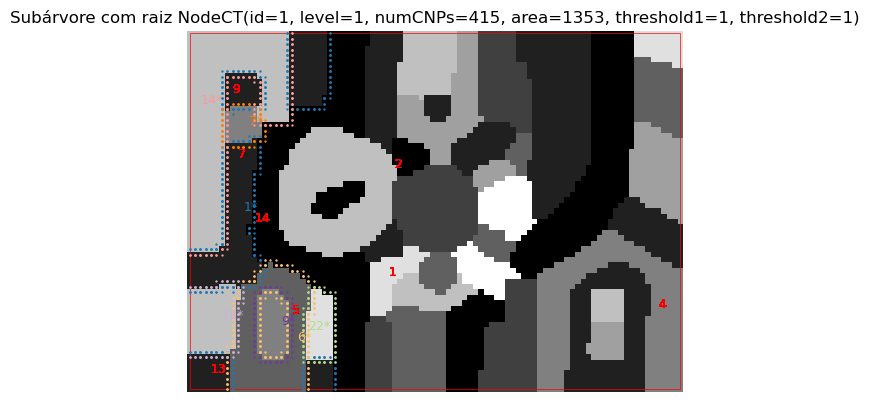

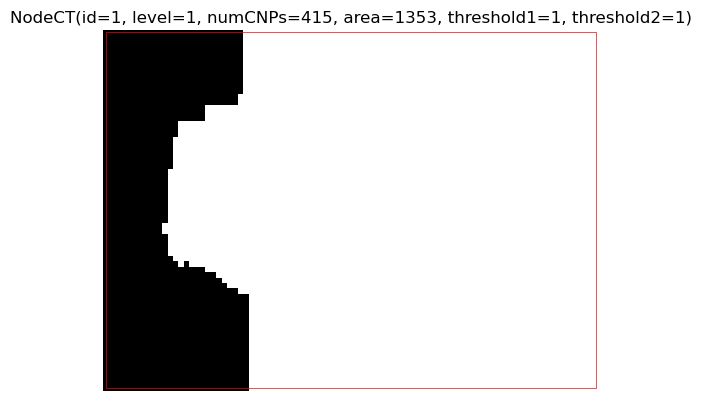

In [33]:
S = maxtree.getNode(1)
showNodesOfSubtree(mintree, S)
showNode(S)

#unionNodes: [1: 1, 6: 3, 7: 4, 9: 4, 18: 6, 22: 7, 14: 6, ]

### 4.2 Analyzing collections $F_\lambda$ and $B_L$

In [36]:
adjust = mta.ComponentTreeAdjustment(mintree, maxtree)


newGrayLevel = S.parent.level
type_treeBeUpdated = False #False=mintree and True=maxtree
tree = maxtree if type_treeBeUpdated else mintree
print(tree.isMaxtree)
C_S = []
tau_star = tree.getSC(S.cnps[0])
for n in S.BFSTraversal():
    if (not type_treeBeUpdated and tau_star.level < n.level) or (type_treeBeUpdated and tau_star.level > n.level):
        tau_star = tree.getSC(n.cnps[0]) 
        C_S = n.cnps + C_S  
    else:
        C_S.extend(n.cnps) 


(mapF, B_L) = adjust.buildCollections(mintree, C_S, newGrayLevel, type_treeBeUpdated)

level_tau_star = max([mintree.getSC(p).level for p in C_S])
print("level(tau_S):", S.level)
print("newGrayLevel:", newGrayLevel)
print("level(tau_star):", tau_star.level)
print("F_λ:", mapF)
print("B_L:", B_L)

False
level(tau_S): 1
newGrayLevel: 0
level(tau_star): 7
F_λ: {0: [NodeCT(id=14, level=0)], 1: [NodeCT(id=7, level=1), NodeCT(id=13, level=1), NodeCT(id=9, level=1)], 2: [NodeCT(id=6, level=2)], 3: [NodeCT(id=5, level=3)], 4: [NodeCT(id=4, level=4)], 5: [NodeCT(id=3, level=5)], 6: [NodeCT(id=2, level=6)], 7: [NodeCT(id=1, level=7)]}
B_L: []


In [38]:

adjust.updateTree2(mintree, S)

#after, pruning the maxtree
maxtree.prunning(S)

#reconstructed images of both trees
img_g_vector_maxtree = maxtree.reconstructionImage()
img_g_vector_mintree = mintree.reconstructionImage()

print("The reconstruction images are equals?", (img_g_vector_maxtree == img_g_vector_mintree).all() )

The reconstruction images are equals? True
newGrayLevel: 0
Intervalo: [0, 7]
|cnpsSubtree| = 1353 = Area(rSubtree)= 1353
nodeTauStar: Id:1; level:7
unionNodes: [1:7:0, 2:6:0, 4:4:0, 5:3:0, 7:1:0, ]
Lambda:0; size(F_lambda):1
Lambda:1; size(F_lambda):3
Lambda:2; size(F_lambda):1
Lambda:3; size(F_lambda):1
Lambda:4; size(F_lambda):1
Lambda:5; size(F_lambda):1
Lambda:6; size(F_lambda):1


Imagem and its min-tree representation. The indexes of min-tree nodes are shown as label in the imagem.


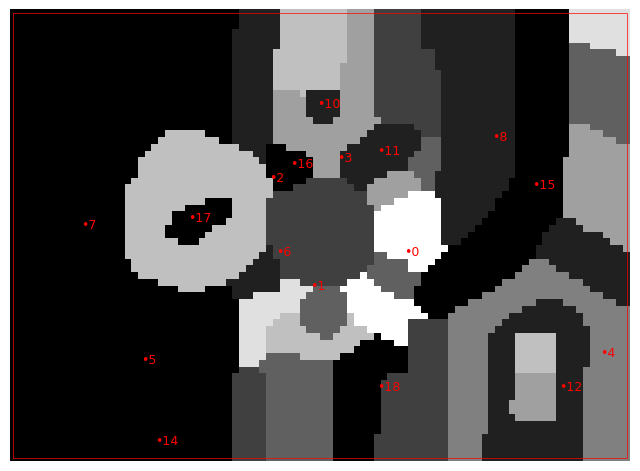

Each node is represented by <index>: <gray level>

              0: 8: 166 
                  |
              1: 7: 121 
                  |
              2: 6: 1141 
     ┌────────────┴────────────┐
 17: 0: 44                 3: 5: 392                                                                
                 ┌─────────────┴──────────────┐                                                     
             10: 1: 23                    4: 4: 493                                                 
                             ┌────────────────┴─────────────────┐                                   
                         12: 1: 244                         5: 3: 598                               
                                                                |                                   
                                                            6: 2: 620                               
                                          ┌────────────┬────────┴──┬──────────────────┐      

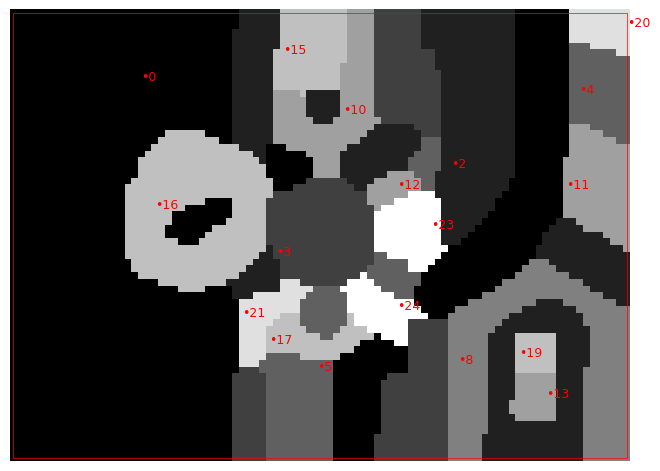

Each node is represented by <index>: <gray level>

                                                                    0: 0: 2526 
                                                                        |
                                                                    2: 1: 986 
                                        ┌───────────────────────────────┴────────────┬──────────────────┐
                                    3: 2: 620                                    4: 3: 112          13: 5: 44 
              ┌─────────────────────────┴┬───────────┬────────────┐            ┌─────┴──────┐           |     
          5: 3: 265                  8: 4: 378   10: 5: 172   16: 6: 373   11: 5: 146   20: 7: 53   19: 6: 36 
     ┌────────┴────────┐                             |                                                        
 12: 5: 30         17: 6: 66                     15: 6: 123                                                   
     |           ┌─────┴─────┐                         

In [40]:
showTree(mintree)
print("\n\n")
showTree(maxtree)

Imagem and its min-tree representation. The indexes of min-tree nodes are shown as label in the imagem.


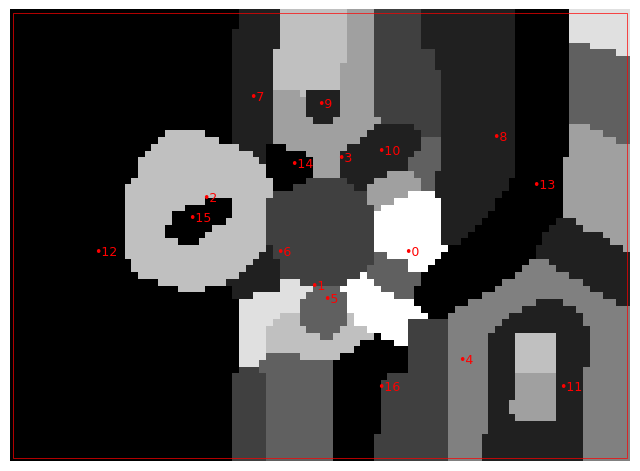

Each node is represented by <index>: <gray level>

                                                                           0: 8: 166 
                                                                               |
                                                                           1: 7: 121 
                                                                               |
                                                                           2: 6: 598 
                                                                  ┌────────────┴─────────────┐
                                                              3: 5: 392                  15: 0: 44 
                                                   ┌──────────────┴──────────────┐                 
                                               4: 4: 378                      9: 1: 23             
                                  ┌────────────────┴─────────────────┐                             
                              5: 3

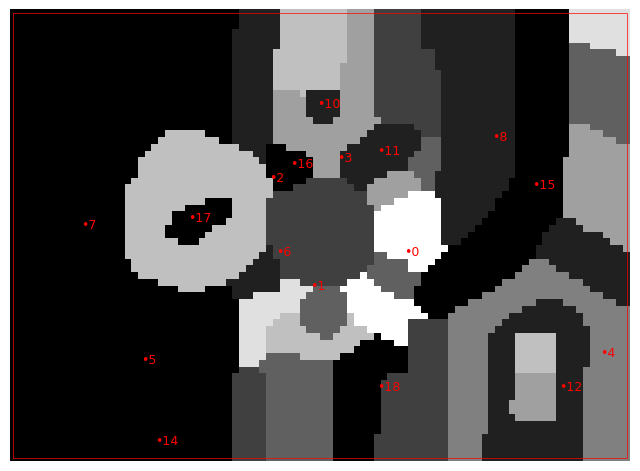

Each node is represented by <index>: <gray level>

              0: 8: 166 
                  |
              1: 7: 121 
                  |
              2: 6: 1141 
     ┌────────────┴────────────┐
 17: 0: 44                 3: 5: 392                                                                
                 ┌─────────────┴──────────────┐                                                     
             10: 1: 23                    4: 4: 493                                                 
                             ┌────────────────┴─────────────────┐                                   
                         12: 1: 244                         5: 3: 598                               
                                                                |                                   
                                                            6: 2: 620                               
                                          ┌────────────┬────────┴──┬──────────────────┐      

In [43]:
mintree_ok = mta.ComponentTree(img_g_vector_mintree, num_rows, num_cols, False, 1.5)
showTree(mintree_ok)
showTree(mintree)


# Other simple images for testing

- Example image created by Wonder

In [ ]:
img_wonder = np.array([
[203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203],
[203,203,203, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,203,203,203,203,203,203,203,203],
[203,203, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,203,203,203,203,203,203,203],
[203,203, 78, 78,126,126,126,126,126,126,126, 78, 78, 78, 78, 78, 78, 78,203,203,203, 54, 54,203,203],
[203,203, 78, 78,126, 38, 38, 38,126,126,126, 78, 78, 78, 78, 78, 78, 78,203,203, 54, 54, 54, 54,203],
[203,203, 78, 78,126, 38, 38, 38,126,126,126, 78, 78, 78, 78, 78, 78, 78,203, 54, 54, 54, 80, 54,203],
[203,203, 78, 78,126, 38, 38, 38,126, 78, 78, 78, 78, 78, 78, 78, 78, 78,203, 54, 80, 54, 54, 54,203],
[203, 78, 78, 78,126, 38, 38,126,126, 78, 78, 78,203,203,203,203,203,203,203, 54, 54, 54, 54,203,203],
[203, 78, 78, 78,126,126,126,126, 78, 78,203,203,203,203,203,203,203,203, 54, 54, 54, 54, 54,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78,203,203,253,253,253,203,203,203, 54, 80, 54, 54, 54,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78,203,203,253,253,253,203,203, 54, 54, 54, 54, 54,203,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78,203,203,253,253,253,203,203,203, 54, 54, 54,203,203,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78, 78,203,203,203,203,203,203,203,203,203,203,203,203,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78, 78,203,203,203,126,126,126,126,203,203,203,203,203,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78, 78,203,203,126,126,126,126,126,126,126,126,126,203,203,203],
[203, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,203,203,126,126,126,126,126,126, 72,126,126,203,203,203],
[203, 78, 78, 78, 78, 78, 78,161,161,161, 78, 78,203,126,126,126,126,126,126, 72, 72,126,126,126,203],
[203, 78, 78, 78, 78, 78,161,161,161,161,161, 78,203,126,126,126,126,126, 72, 72, 72,126,126,126,203],
[203, 78, 78, 78, 78, 78,161, 30, 30, 30,161, 78,203,203,126,126,126, 72, 72, 72, 72, 72,126,126,203],
[203, 78, 78, 78, 78, 78,161, 30, 90, 30,161, 78, 78,203,126,126, 72, 72, 72, 72, 72, 72, 72,126,203],
[203, 78, 78, 78, 78, 78,161, 30, 30, 30,161, 78, 78,203,203,126,126,126,126,126,126,126,126,126,203],
[203, 78, 78, 78, 78, 78,161,161,161,161,161, 78, 78, 78,203,203,126,126,126,126,126,126,126,203,203],
[203, 78, 78, 78, 78, 78,161,161,161,161,161, 78, 78, 78,203,203,203,203,126,126,126,126,203,203,203],
[203,203, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,203,203,203,203,203,203,203,203,203,203],
[203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203]
])

num_rows, num_cols = img_wonder.shape
img_wonder_vector = img_wonder.ravel()

maxtree = mta.ComponentTree(img_wonder_vector, num_rows, num_cols, True, 1.5)
mintree = mta.ComponentTree(img_wonder_vector, num_rows, num_cols, False, 1.5)

showLevelSets(img_wonder)
showTree(mintree)
showTree(maxtree)

- Image of the DGMM paper

In [ ]:
img_dgmm = np.array([
    [7, 7, 7, 7, 7, 7, 7, 7, 7],
    [7, 5, 5, 5, 7, 7, 7, 7, 7],
    [7, 5, 1, 5, 7, 7, 7, 7, 7],
    [7, 5, 1, 5, 7, 2, 2, 2, 7],
    [7, 5, 1, 5, 7, 2, 4, 2, 7],
    [7, 5, 5, 5, 7, 2, 2, 2, 7],
    [7, 7, 7, 7, 7, 2, 4, 2, 7],
    [7, 7, 7, 7, 7, 2, 2, 2, 7],
    [7, 7, 7, 7, 7, 7, 7, 7, 7]
])


num_rows, num_cols = img_dgmm.shape
img_dgmm_vector = img_dgmm.ravel()

maxtree = mta.ComponentTree(img_dgmm_vector, num_rows, num_cols, True, 1.5)
mintree = mta.ComponentTree(img_dgmm_vector, num_rows, num_cols, False, 1.5)

showLevelSets(img_dgmm)
print("\n\n")
showTree(mintree)
print("\n\n")
showTree(maxtree)